In [1]:
from collections import defaultdict
import json
import numpy as np
class COCOParser:
    def __init__(self, anns_file, imgs_dir):
        with open(anns_file, 'r') as f:
            coco = json.load(f)
            
        self.annIm_dict = defaultdict(list)        
        self.cat_dict = {} 
        self.annId_dict = {}
        self.im_dict = {}
        self.licenses_dict = {}
        for ann in coco['annotations']:           
            self.annIm_dict[ann['image_id']].append(ann) 
            self.annId_dict[ann['id']]=ann
        for img in coco['images']:
            self.im_dict[img['id']] = img
        for cat in coco['categories']:
            self.cat_dict[cat['id']] = cat
        for license in coco['licenses']:
            self.licenses_dict[license['id']] = license
    def get_imgIds(self):
        return list(self.im_dict.keys())
    def get_annIds(self, im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        return [ann['id'] for im_id in im_ids for ann in self.annIm_dict[im_id]]
    def load_anns(self, ann_ids):
        im_ids=ann_ids if isinstance(ann_ids, list) else [ann_ids]
        return [self.annId_dict[ann_id] for ann_id in ann_ids]        
    def load_cats(self, class_ids):
        class_ids=class_ids if isinstance(class_ids, list) else [class_ids]
        return [self.cat_dict[class_id] for class_id in class_ids]
    def get_imgLicenses(self,im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        lic_ids = [self.im_dict[im_id]["license"] for im_id in im_ids]
        return [self.licenses_dict[lic_id] for lic_id in lic_ids]

In [2]:
def get_imgIds(self):
        return list(self.im_dict.keys())

In [3]:
def get_annIds(self, im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        return [ann['id'] for im_id in im_ids for ann in self.annIm_dict[im_id]]

In [4]:
def load_anns(self, ann_ids):
    im_ids=ann_ids if isinstance(ann_ids, list) else [ann_ids]
    return [self.annId_dict[ann_id] for ann_id in ann_ids]        

In [5]:
def load_cats(self, class_ids):
    class_ids=class_ids if isinstance(class_ids, list) else [class_ids]
    return [self.cat_dict[class_id] for class_id in class_ids]

In [7]:
def get_imgLicenses(self,im_ids):
    im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
    lic_ids = [self.im_dict[im_id]["license"] for im_id in im_ids]
    return [self.licenses_dict[lic_id] for lic_id in lic_ids]

In [8]:
coco_annotations_file="D:/COCO Dataset/annotations/instances_val2017.json"
coco_images_dir="D:/COCO Dataset/val2017"
coco= COCOParser(coco_annotations_file, coco_images_dir)

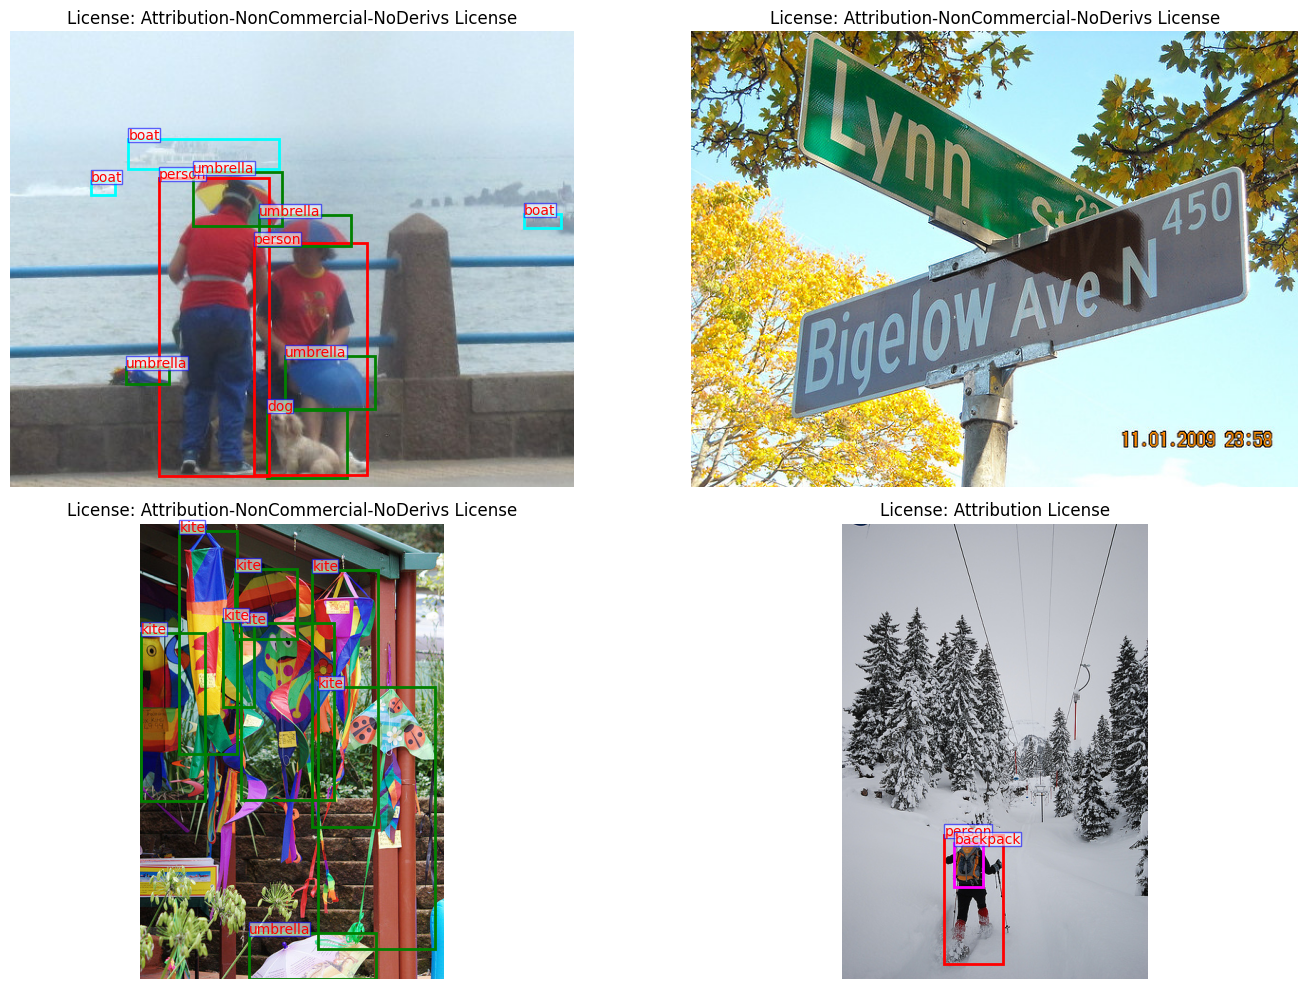

In [13]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# define a list of colors for drawing bounding boxes
color_list = ["pink", "red", "teal", "blue", "orange", "yellow", "black", "magenta","green","aqua"]*10
num_imgs_to_disp = 4
total_images = len(coco.get_imgIds()) # total number of images
sel_im_idxs = np.random.permutation(total_images)[:num_imgs_to_disp]
img_ids = coco.get_imgIds()
selected_img_ids = [img_ids[i] for i in sel_im_idxs]
ann_ids = coco.get_annIds(selected_img_ids)
im_licenses = coco.get_imgLicenses(selected_img_ids)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = ax.ravel()
for i, im in enumerate(selected_img_ids):
    image = Image.open(f"{coco_images_dir}/{str(im).zfill(12)}.jpg")
    ann_ids = coco.get_annIds(im)
    annotations = coco.load_anns(ann_ids)
    for ann in annotations:
        bbox = ann['bbox']
        x, y, w, h = [int(b) for b in bbox]
        class_id = ann["category_id"]
        class_name = coco.load_cats(class_id)[0]["name"]
        license = coco.get_imgLicenses(im)[0]["name"]
        color_ = color_list[class_id]
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')
        t_box=ax[i].text(x, y, class_name,  color='red', fontsize=10)
        t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
        ax[i].add_patch(rect)
    
    ax[i].axis('off')
    ax[i].imshow(image)
    ax[i].set_xlabel('Longitude')
    ax[i].set_title(f"License: {license}")
plt.tight_layout()
plt.show()

In [26]:
import cv2
import numpy as np

# Load YOLO
net = cv2.dnn.readNet("D:/Курсовой проект/Diploma project (Дилом)/Src/CNN model/yolov3.weights",
                      "D:/Курсовой проект/Diploma project (Дилом)/Src/CNN model/yolov3.cfg")
classes = []
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Set the input size for the network
input_width = 416
input_height = 416

# Load camera
cap = cv2.VideoCapture(0)

while True:
    # Read frame from camera
    ret, frame = cap.read()

    # Create a blob from the frame
    blob = cv2.dnn.blobFromImage(frame, 1/255.0, (input_width, input_height), swapRB=True, crop=False)

    # Set the input to the network
    net.setInput(blob)

    # Run forward pass and get output layers
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    outs = net.forward(output_layers)

    # Initialize lists for bounding boxes, confidences, and class IDs
    boxes = []
    confidences = []
    class_ids = []

    # Process each output layer
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.5 and classes[class_id] == 'person':
                # Calculate coordinates of bounding box
                box = detection[0:4] * np.array([frame.shape[1], frame.shape[0], frame.shape[1], frame.shape[0]])
                (center_x, center_y, width, height) = box.astype("int")
                x = int(center_x - (width / 2))
                y = int(center_y - (height / 2))

                # Append bounding box, confidence, and class ID to lists
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply non-maximum suppression to eliminate redundant overlapping boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # Draw bounding boxes and labels on the frame
    for i in indices:
        i = i[0]
        (x, y, w, h) = boxes[i]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, "Person", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the resulting frame
    cv2.imshow("Real-time Person Detection", frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close windows
cap.release()
cv2.destroyAllWindows()


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\dnn\src\darknet\darknet_importer.cpp:210: error: (-212:Parsing error) Failed to open NetParameter file: D:/Курсовой проект/Diploma project (Дилом)/Src/CNN model/yolov3.cfg in function 'cv::dnn::dnn4_v20221220::readNetFromDarknet'


In [27]:
import cv2
import torch
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Load the pre-trained model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Set device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Load the COCO class labels
LABELS = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train',
    'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella',
    'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork',
    'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli',
    'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant',
    'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop',
    'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
    'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors',
    'teddy bear', 'hair drier', 'toothbrush'
]

# Transformations to apply to input image
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Function to perform object detection on the input image
def detect_objects(image):
    image = transform(image).unsqueeze(0).to(device)
    outputs = model(image)
    
    # Get the predicted bounding boxes, labels, and scores
    boxes = outputs[0]['boxes'].detach().cpu().numpy()
    labels = outputs[0]['labels'].detach().cpu().numpy()
    scores = outputs[0]['scores'].detach().cpu().numpy()

    # Filter out detections with low confidence
    threshold = 0.5
    filtered_boxes = boxes[scores > threshold]
    filtered_labels = labels[scores > threshold]
    
    # Draw bounding boxes on the image
    for box, label in zip(filtered_boxes, filtered_labels):
        x1, y1, x2, y2 = box.astype(int)
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(image, LABELS[label], (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    
    return image

# Function to read frames from the camera and perform object detection
def process_camera_feed():
    capture = cv2.VideoCapture(0)  # Use the default camera (change index if needed)
    while True:
        ret, frame = capture.read()
        if not ret:
            break
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = detect_objects(frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        
        cv2.imshow('Object Detection', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    capture.release()
    cv2.destroyAllWindows()

# Start processing the camera feed
process_camera_feed()


c:\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - img is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'img'
>  - img is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'img'
